# Run PEST and Parallel PEST
### This should be super easy ~

In [1]:
import os
import shutil
import warnings
warnings.filterwarnings("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning) 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt;
import psutil
import sys
import pyemu
import flopy
import swatp_pst
assert "dependencies" in flopy.__file__
assert "dependencies" in pyemu.__file__
assert "dependencies" in swatp_pst.__file__

# 01. Specify a path to the model folder

In [2]:
# path to project directory
prj_dir = "D:\\spark\\jj\\opt_3rd" # win
# prj_dir = "D:\\jj\\opt_3rd" # win

In [3]:
main_opt_path = os.path.join(prj_dir, 'main_opt')
os.chdir(main_opt_path)

In [4]:
os.getcwd()

'D:\\spark\\jj\\opt_3rd\\main_opt'

# 02. Perform GSA

In [5]:
# pst_sen = pyemu.Pst(os.path.join(main_opt_path,"swatp_nw_ies.pst"))
# pst_sen.write('swatp_nw_sen.pst', version=2) # write new IES control file

In [8]:
os.getcwd()

'D:\\jj\\opt_3rd\\main_opt'

In [5]:
pst_sen = pyemu.Pst(os.path.join(main_opt_path,"swatp_dummy.pst"))
pst_sen.pestpp_options["gsa_method"] = "morris"
pst_sen.pestpp_options["gsa_morris_r"] = 100
pst_sen.pestpp_options["gsa_morris_p"] = 100
pst_sen.write('swatp_nw_sen_morris.pst', version=2) # write new IES control file

noptmax:0, npar_adj:13, nnz_obs:78


In [6]:
# set a path to the main directory of model
m_d = os.path.join(prj_dir, "swatp_nw_sen_morris")

In [ ]:
os.chdir(prj_dir) # move the loction to project directory
# run PEST in parallel
pyemu.os_utils.start_workers(
                            main_opt_path, # the folder which contains the "template" PEST dataset
                            "pestpp-sen", #the PEST software version we want to run
                            'swatp_nw_sen_morris.pst', # the control file to use with PEST
                            num_workers=num_workers, #how many agents to deploy
                            worker_root='.', #where to deploy the agent directories; relative to where python is running
                            master_dir=m_d, #the manager directory,
                            # reuse_master=True
                            )

# 03. Let's see how we did:

In [7]:
pst_name = 'swatp_nw_sen_morris.pst'

In [8]:
os.chdir(m_d)
df = pd.read_csv(os.path.join(m_d,pst_name.replace(".pst",".msn")), index_col='parameter_name')
df.head()

,n_samples,sen_mean,sen_mean_abs,sen_std_dev
parameter_name,,,,
alpha,97,5.54596,206.4690,677.582
awc,96,20.06540,78.8815,153.575
canmx,94,-10.96170,73.0193,301.655
cn2,93,-20.09780,59.4769,180.758
cn3_swf,96,-76.66700,455.1040,1051.750


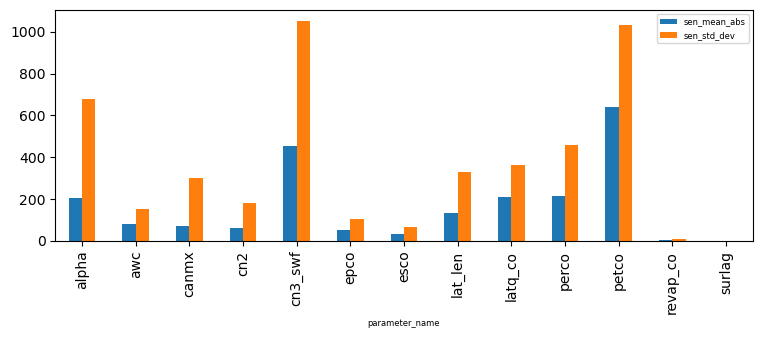

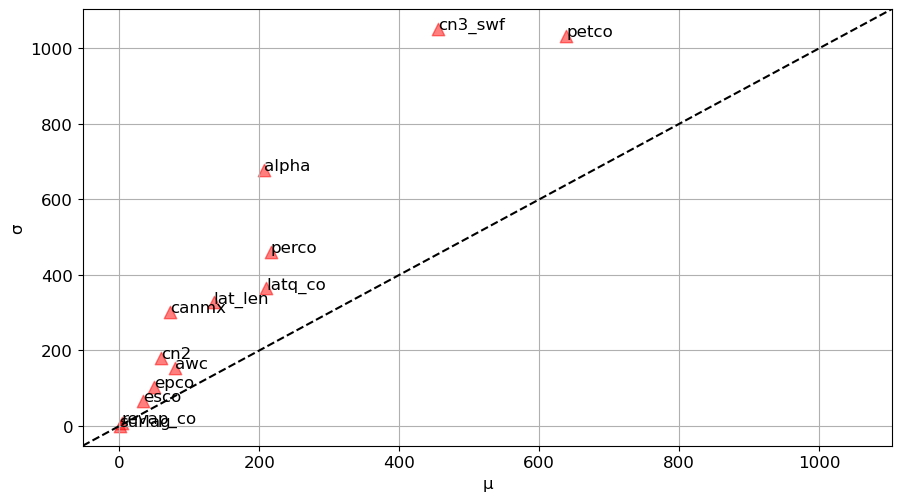

In [9]:

df = df.loc[df.sen_mean_abs>1e-6,:]
df.loc[:,["sen_mean_abs","sen_std_dev"]].plot(kind="bar", figsize=(9,3), fontsize=10)
#ax = plt.gca()
#ax.set_ylim(1,ax.get_ylim()[1]*1.1)
# plt.yscale('log');
fig,ax = plt.subplots(1,1,figsize=(9,5))
tmp_df = df
ax.scatter(tmp_df.sen_mean_abs,tmp_df.sen_std_dev,marker="^",s=80,c="r", alpha=0.5)
# tmp_df = tmp_df.iloc[:8]
for x,y,n in zip(tmp_df.sen_mean_abs,tmp_df.sen_std_dev,tmp_df.index):
    ax.text(x,y,n, fontsize=12)
mx = max(ax.get_xlim()[1],ax.get_ylim()[1])
mn = min(ax.get_xlim()[0],ax.get_ylim()[0])
ax.plot([mn,mx],[mn,mx],"k--")
ax.set_ylim(mn,mx)
ax.set_xlim(mn,mx)
ax.grid()
ax.set_ylabel("σ", fontsize=12)
ax.set_xlabel("μ", fontsize=12)
ax.tick_params(axis='both', labelsize=12)
# plt.legend(
#     fontsize=20, 
# #     loc="lower left"
# )
# ax.set_yscale('log')
plt.tight_layout()